# ResNet50 Model 3

Please refer to the file 'Model_3_Documentation.pdf' for necessary folder structures and other relevant information.

# Load libraries

In [1]:
%matplotlib inline
# python libraries
import os, cv2, itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch
from torch import optim, nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# ensure results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

# return directory
print(os.listdir())

['Model_3_ResNet50_Trained.pt', 'Model_3_Documentation.pdf', '.DS_Store', 'ResNet50 Model 3 - Documentation.pdf', 'ResNet50_Model_3_Trained.pt', 'ResNet50_Model_3.ipynb', 'Model_3_ResNet50_RunTest.ipynb', 'Data_Rubbish']


# Load dataset

In [2]:
# Please ensure data_dir is pointing to the dataset_root/ folder (refer to documentation)
data_dir = './Data_Rubbish'
all_image_path = glob(os.path.join(data_dir, '*', '*.JPG'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
label_type_dict = {
    'No Plastic': 'No Plastic',
    'Mixed Plastic': 'Mixed Plastic',
    'Plastic Bottle': 'Plastic Bottle',
    'Plastic Bags': 'Plastic Bags'
}

In [3]:
df_original = pd.read_csv(os.path.join(data_dir, 'Images_metadata.csv'))
df_original['path'] = df_original['image_id_root'].map(imageid_path_dict.get)
df_original['label'] = df_original['label'].map(label_type_dict.get)
df_original['label_num'] = pd.Categorical(df_original['label']).codes
df_original.head()

,image_id,image_id_root,label,path,label_num
0,IMG_0409.JPG,IMG_0409,No Plastic,./Data_Rubbish/Images/IMG_0409.JPG,1
1,IMG_0422.JPG,IMG_0422,No Plastic,./Data_Rubbish/Images/IMG_0422.JPG,1
2,IMG_0440.JPG,IMG_0440,No Plastic,./Data_Rubbish/Images/IMG_0440.JPG,1
3,IMG_0449.JPG,IMG_0449,No Plastic,./Data_Rubbish/Images/IMG_0449.JPG,1
4,IMG_0451.JPG,IMG_0451,No Plastic,./Data_Rubbish/Images/IMG_0451.JPG,1


# Set Model

In [4]:
# feature_extract is a boolean that defines finetuning or feature extracting. 
# If feature_extract = False, the model is finetuned and all model parameters are updated. 
# If feature_extract = True, only the last layer parameters are updated, the others remain fixed.
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [5]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):

    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18, resnet34, resnet50, resnet101
        """
        model_ft = models.resnet50(pretrained=True)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [6]:
model_name = "resnet"
num_classes = 4
feature_extract = False
# Initialise the model
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
# Define the device:
# device = torch.device('cuda:0') # If using GPU
device = torch.device('cpu')
# Put the model on the device:
model = model_ft.to(device)

In [7]:
norm_mean = (0.485, 0.456, 0.406)
norm_std = (0.229, 0.224, 0.225)
# define the transformation of the images.
img_transform = transforms.Compose([transforms.Resize((input_size,input_size)), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

In [8]:
# Define a pytorch dataloader for this dataset
class Images(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['label_num'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [9]:
# Define the data set using the table df_original and using the defined transitions (img_transform)
data_set = Images(df_original, transform=img_transform)
data_loader = DataLoader(data_set, batch_size=4, shuffle=True, num_workers=0)

# Load trained model

In [10]:
from IPython.display import FileLink, FileLinks
FileLinks('.') # lists all downloadable files on server

./
  Model_3_ResNet50_Trained.pt
  Model_3_Documentation.pdf
  .DS_Store
  ResNet50 Model 3 - Documentation.pdf
  ResNet50_Model_3_Trained.pt
  ResNet50_Model_3.ipynb
  Model_3_ResNet50_RunTest.ipynb
./Data_Rubbish/
  .DS_Store
  Images_metadata.csv
./Data_Rubbish/Images/
  IMG_0821.JPG
  IMG_0942.JPG
  IMG_0765.JPG
  IMG_0981.JPG
  IMG_0611.JPG
  IMG_0770.JPG
  IMG_0600.JPG
  IMG_0761.JPG
  IMG_0548.JPG
  IMG_0776.JPG
  IMG_6957.JPG
  IMG_6943.JPG
  IMG_6994.JPG
  IMG_6980.JPG
  IMG_0842.JPG
  IMG_6981.JPG
  IMG_6995.JPG
  IMG_0472.JPG
  IMG_6956.JPG
  IMG_0921.JPG
  IMG_6968.JPG
  IMG_6954.JPG
  IMG_6997.JPG
  IMG_6996.JPG
  IMG_6955.JPG
  IMG_6969.JPG
  IMG_6945.JPG
  IMG_6951.JPG
  IMG_6979.JPG
  IMG_0449.JPG
  IMG_6992.JPG
  IMG_0676.JPG
  IMG_0460.JPG
  IMG_6978.JPG
  IMG_6950.JPG
  IMG_6944.JPG
  IMG_0500.JPG
  IMG_6952.JPG
  IMG_6946.JPG
  IMG_6985.JPG
  IMG_6990.JPG
  IMG_0715.JPG
  IMG_6976.JPG
  IMG_6962.JPG
  IMG_6989.JPG
  IMG_6988.JPG
  IMG_6963.JPG
  IMG_6977.JPG
  IMG_6949.JPG
  IMG_6961.JPG
  IMG_6975.JPG
  IMG_0451.JPG
  IMG_0479.JPG
  IMG_6974.JPG
  IMG_6960.JPG
  IMG_6948.JPG
  IMG_0518.JPG
  IMG_6964.JPG
  IMG_6970.JPG
  IMG_6958.JPG
  IMG_0497.JPG
  IMG_0440.JPG
  IMG_0657.JPG
  IMG_0469.JPG
  IMG_6959.JPG
  IMG_6971.JPG
  IMG_6965.JPG
  IMG_0509.JPG
  IMG_0910.JPG
  IMG_0735.JPG
  IMG_6973.JPG
  IMG_6967.JPG
  IMG_6998.JPG
  IMG_0682.JPG
  IMG_0873.JPG
  IMG_6966.JPG
  IMG_6972.JPG
  IMG_0522.JPG
  IMG_0948.JPG
  IMG_0753.JPG
  IMG_0752.JPG
  IMG_0785.JPG
  IMG_0782.JPG
  IMG_0806.JPG
  IMG_0422.JPG
  IMG_0409.JPG
  IMG_0582.JPG

In [11]:
# Specify a path
PATH = './Model_3_ResNet50_Trained.pt'

In [12]:
# Load
model = torch.load(PATH, map_location=torch.device('cpu'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Predict on test dataset

In [13]:
model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(data_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# Reporting predictions on test dataset

# Generate a confusion matrix

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

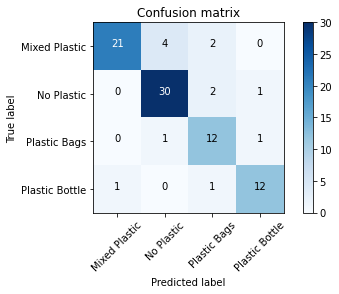

In [15]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['Mixed Plastic', 'No Plastic', 'Plastic Bags', 'Plastic Bottle']

plot_confusion_matrix(confusion_mtx, plot_labels)

# Generate a classification report

In [16]:
report_test = classification_report(y_label, y_predict, target_names=plot_labels)
print(report_test)

                precision    recall  f1-score   support

 Mixed Plastic       0.95      0.78      0.86        27
    No Plastic       0.86      0.91      0.88        33
  Plastic Bags       0.71      0.86      0.77        14
Plastic Bottle       0.86      0.86      0.86        14

      accuracy                           0.85        88
     macro avg       0.84      0.85      0.84        88
  weighted avg       0.86      0.85      0.85        88



# Generate classification label error plot

Text(0, 0.5, 'Fraction classified incorrectly')

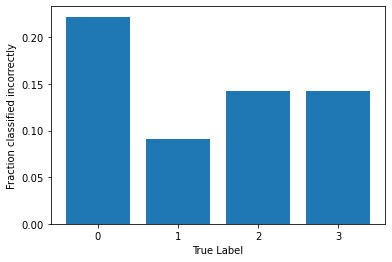

In [17]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(4),label_frac_error)
plt.xlabel('True Label')
plt.xticks(np.arange(0,4))
plt.ylabel('Fraction classified incorrectly')